# Amazon Review Helpfulness 
This notebook demonstrates predicting if a given review (for an Amazon Product) is helpful / unhelpful, using FastAI libraries. 
The data is sourced from http://jmcauley.ucsd.edu/data/amazon/. We are using the subcategory 'Books' in this tutorial.


# Data Preparation


The 'Books' sub-category contains 8,898,041 records, with the following schema:

```json
{
  "reviewerID": "A2SUAM1J3GNN3B",
  "asin": "0000013714",
  "reviewerName": "J. McDonald",
  "helpful": [2, 3],
  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
  "overall": 5.0,
  "summary": "Heavenly Highway Hymns",
  "unixReviewTime": 1252800000,
  "reviewTime": "09 13, 2009"
}
```

For our purposes, we are only interested in the 'reviewText' & 'helpful' fields. The reviewText is the actual review that a user provides for any given product. The 'helpful' field indicates how helpul was the review, as perceived by other users. The value contained in it is a list of length 2, where the first item indicates the number of users that voted the review to be helpful, and the second item indicates how many total votes the review received (indicating that the rest of the reviews were not helpful). For instance, a value of [3, 5] indicates that 3 out of 5 users marked the review helpful, while 2 marked it as unhelpful.

As a first step, we download the GZ compressed files locally. Please note this is a large file (~9GB uncompressed), so it may take a while to download the files.

In [7]:
!pwd
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz
!gunzip -d reviews_Books_5.json.gz

/mnt/batch/tasks/shared/LS_root/mounts/clusters/gasidnn/code/Users/gasi
--2021-07-21 22:27:40--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3223678899 (3.0G) [application/x-gzip]
Saving to: ‘reviews_Books_5.json.gz’

reviews_Books_5.jso   0%[                    ]  27.43M   856KB/s    eta 49m 9s ^C

gzip: reviews_Books_5.json.gz: unexpected end of file


Once downloaded, we can use [Dask](https://docs.dask.org/en/latest/) to process the data, as using pandas can cause out of memory issues. Dask is a parallel computing framework in Python, that uses lazy and distributed computations to efficiently handle large data. 
Specifically, we will parse the unzipped JSON file as a Dask [Bag](https://examples.dask.org/bag.html). From there, we will apply a transformation function, that drops all but the two fields that we're interested in, 'reviewText' and 'helpful'.

In the end, we'll write the dataframe as a [parquet](https://parquet.apache.org/) file, which is columnar storage format, especially well suited for large datasets.

In [ ]:
from dask.distributed import Client, progress
import json
import dask.bag as db


def flatten(record):
    """Function that just reads in the 'reviewText' and 'helpful' fields from the record."""
    return {
        "reviewText": record["reviewText"],
        "helpful": record["helpful"],
    }

# Increase the n_workers based on number of machines / prallel processes that we want. If using a single machine, we might 
# run into out of memory errors if this is large. 
client = Client(n_workers=1, threads_per_worker=2)

# Lazy read the ~9GB JSON data using Dask Bag
data = db.read_text("./reviews_Books_5.json").map(json.loads)

# Parse the JSON data, and only read the two columns of interest - "reviewText", "helpful"
df = data.map(flatten).to_dataframe()

# Expand the 'helpful' column
df[['num_helpful_votes', 'num_total_votes']] = dd.DataFrame(df.helpful.to_list(), index= df.index)

# Calculate 'helpful_ratio'
def expand_helpful(row):
    assert len(row['helpful']) == 2
    row['helpful_ratio'] = 0. if row['helpful'][1] == 0 else float(row['helpful'][0] / row['helpful'][1])
    row.drop(columns=["helpful"])
    return row

df = df.apply(expand_helpful, axis=1)

# Write the resulting dataframe to a parquet file
df.to_parquet("./amazon_books_computed.parquet.snappy", compression="snappy", engine="pyarrow")

In [1]:
import pandas as pd
import numpy as np
import os

We can directly load the parquet file as a pandas DataFrame. Note that since we've dropped all but two columns from the original dataset, the size of the dataset is smaller than before. If we still run into memory issues, consider using Dask to do the data pre-processing.

> Note: The parquet file used below was generated separately (i.e. not using the exact steps in Dask above). As such, the schema is a little bit different.

In [6]:
df = pd.read_parquet("./amazon_books_computed.parquet.snappy")
pd.set_option('display.max_colwidth', 500)
df.head()

,reviewText,summary,num_helpful_votes,num_total_votes,helpful_ratio
__null_dask_index__,,,,,
0,Spiritually and mentally inspiring! A book that allows you to question your morals and will help you discover who you really are!,Wonderful!,0,0,NaN
1,"This is one my must have books. It is a masterpiece of spirituality. I'll be the first to admit, its literary quality isn't much. It is rather simplistically written, but the message behind it is so powerful that you have to read it. It will take you to enlightenment.",close to god,0,2,0.000000
2,"This book provides a reflection that you can apply to your own life.And, a way for you to try and assess whether you are truly doing the right thing and making the most of your short time on this plane.",Must Read for Life Afficianados,0,0,NaN
3,"I first read THE PROPHET in college back in the 60's. The book had a revival as did anything metaphysical in the turbulent 60's. It had a profound effect on me and became a book I always took with me. After graduation I joined the Peace Corps and during stressful training in country (Liberia) at times of illness and the night before I left, this book gave me great comfort. I read it before I married, just before and again after my children were born and again after two near fatal illnesses. ...",Timeless for every good and bad time in your life.,0,0,NaN
4,"A timeless classic. It is a very demanding and assuming title, but Gibran backs it up with some excellent style and content. If he had the means to publish it a century or two earlier, he could have inspired a new religion.From the mouth of an old man about to sail away to a far away destination, we hear the wisdom of life and all important aspects of it. It is a messege. A guide book. A Sufi sermon. Much is put in perspective without any hint of a dogma. There is much that hints at hi...",A Modern Rumi,7,9,0.777832


In [4]:
df.shape

(8898041, 5)

### Drop samples that have less than 50 total votes
For having confidence in the reviews, to determine if they were helpful or not, we need to select only those samples which have been voted-on by enough users. For a review to be considered helpful or unhelpful, we only considers reviews that have at least a total of 50 votes.

In [5]:
# Filter all rows for which we had atleast 50 total votes
trimmed_df = df.loc[df["num_total_votes"] > 49]
trimmed_df.shape

(106996, 5)

### Verify that there are no NaNs in the 'helpful_ratio' column
If there are, we may need to fill them by 0 (unhelpful)


In [9]:
assert trimmed_df.helpful_ratio.isna().sum() == 0

## Data labelling
If 75% of people marked it as helpful, label it 1, else label it 0. This gives us enough confidence to say that the review is helpful.

In [12]:
conditions = [
    (trimmed_df["helpful_ratio"] >= 0) & (trimmed_df["helpful_ratio"] < 0.75),
    trimmed_df["helpful_ratio"] >= 0.75
]

# 0 = Unhelpful, 1 = Helpful
labels = [0, 1]

trimmed_df["category"] = np.select(conditions, labels)

<ipython-input-12-5d0adf947b14>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df["category"] = np.select(conditions, labels)


After filtering our data above, we end up with an unbalanced number of records that are helpful/unhelpful.

In [17]:
trimmed_df["category"].value_counts()    # Data is unbalanced

1    71071
0    35925
Name: category, dtype: int64

### Drop extraneous columns
We only want the review text and the category columns in our dataset

In [18]:
trimmed_df.dtypes

reviewText            object
summary               object
num_helpful_votes      int64
num_total_votes        int64
helpful_ratio        float32
category               int64
dtype: object

In [20]:
labeled_review_pdf = trimmed_df.drop(columns=["summary", "num_helpful_votes", "num_total_votes", "helpful_ratio"])
labeled_review_pdf.dtypes, labeled_review_pdf.shape

(reviewText    object
 category       int64
 dtype: object,
 (106996, 2))

### Save the resulting prepped data as a csv

In [2]:
labeled_review_pdf.to_csv("./reviews_Books_labeled.csv", header=True, index=False)

In [3]:
labeled_review_pdf.category.value_counts()

1    71071
0    35925
Name: category, dtype: int64

## Split the dataset into train / test

In [2]:
from sklearn.model_selection import train_test_split

labeled_review_pdf = pd.read_csv("./reviews_Books_labeled.csv")

# Since the data is unbalanced, stratify the train-test splits on the category.
train_df, test_df = train_test_split(
    labeled_review_pdf, test_size=0.20, stratify=labeled_review_pdf["category"], random_state=42
)
train_df.shape, test_df.shape

((85596, 2), (21400, 2))

In [3]:
train_df["category"].value_counts(), test_df["category"].value_counts()

(1    56856
 0    28740
 Name: category, dtype: int64,
 1    14215
 0     7185
 Name: category, dtype: int64)

# Modelling

The following steps demonstrate using FastAI NLP to build a model for predicting whether a given review is hepful or not.

In [4]:
from fastai.text.all import *

## Language Model

Create a TextDataLoader from the training dataframe. Creating a text data loader in FastAI takes care of all the pre-proessing required on the text column (such as tokenizing / numericalizing). We also pass in an 'is_lm' flag, set to True, which indicates that the text is to be prepped for creating a Language Model.

In [7]:
dls_lm = TextDataLoaders.from_df(
    train_df, seed=42, seq_len=72,
    text_col="reviewText", label_col="category",
    valid_pct = 0.10, bs = 64, is_lm = True
)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [7]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj you remember those times as a kid when you picked up a book that was truly magical ? xxmaj those were the days of "" a xxmaj wrinkle in xxmaj time "" and "" the xxmaj chronicles of xxmaj narnia "" , where you could be swept away in an amazing world and xxunk desired to become part of that universe . xxmaj the xxmaj harry xxmaj potter books are","xxmaj you remember those times as a kid when you picked up a book that was truly magical ? xxmaj those were the days of "" a xxmaj wrinkle in xxmaj time "" and "" the xxmaj chronicles of xxmaj narnia "" , where you could be swept away in an amazing world and xxunk desired to become part of that universe . xxmaj the xxmaj harry xxmaj potter books are kind"
1,"in a "" real xxmaj simple "" article or a xxunk not in a serious book on organizing . xxmaj decorating help ? xxmaj zilch . xxmaj step - by - step cleaning instructions ? xxmaj nil . xxmaj gaining knowledge about organizing tools available for various storage needs ? xxmaj almost unheard of here . xxmaj again , in a book about organizing xxup now , one would at least expect","a "" real xxmaj simple "" article or a xxunk not in a serious book on organizing . xxmaj decorating help ? xxmaj zilch . xxmaj step - by - step cleaning instructions ? xxmaj nil . xxmaj gaining knowledge about organizing tools available for various storage needs ? xxmaj almost unheard of here . xxmaj again , in a book about organizing xxup now , one would at least expect that"


We finally create the learner for the language model, using a pre-trained [AWD LSTM](https://nlp.fast.ai/) model.

In [9]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

Fine tune the langugage model over our review texts, for 1 epoch. FastAI's `fit_one_cycle()` method using a variable learning rate (as proposed by [Leslie Smith](https://arxiv.org/abs/1708.07120))

In [10]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.183126,4.083890,0.285132,59.375992,2:54:36


FastAI also provides a handy method to find an optimal learning rate for our dataset.

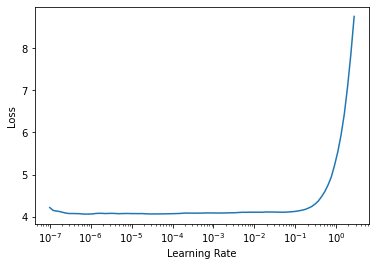

In [11]:
lr_min,lr_steep = learn.lr_find()

In [12]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 7.59e-08, steepest point: 1.91e-06


In [13]:
# All of the layers are trainable = True now.
learn.unfreeze()
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.945498,3.931691,0.302495,50.993118,3:09:11
1,3.774155,3.801546,0.315883,44.770329,3:09:33
2,3.650193,3.751191,0.321655,42.571739,3:09:42


For our purposes, we are only interested in using the language model to be used in the text classifier, and not for predicting the next word (as is generally what a Language Model predicts). The last layer of the neural network is the layer which predicts the next word. As such, we only save the model without the last layer (also known as encoder).

In [14]:
learn.save_encoder('finetuned_train')

Next, we initialize the data-loader required for the text classifier. Note that the 'is_lm' flag is going to be false here, since we have already created the language model above.


In [5]:
# TODO: Is it possible to re-use the above data loader?
dls_classifier = TextDataLoaders.from_df(
    train_df, seed=42,
    text_col="reviewText", label_col="category",
    valid_pct = 0.20, bs = 64, is_lm = False
)

In [6]:
# Create the pre-trained text classifier
classifier = text_classifier_learner(dls_classifier, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

# Use the encoder created above from the language model
classifier = classifier.load_encoder('finetuned_train')

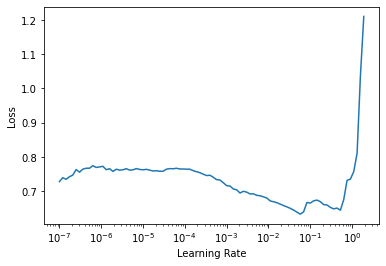

In [18]:
lr_min,lr_steep = classifier.lr_find()

For pre-trained models, it is generally assumed that the weights of the initial layers don't change as often as the later layers (which are more specific to the domain, the specific problem that it is trying to solve). As such, we want to first fine tune the last few layers only, as they will change the most (starting from, say random). Slowly, we'll unfreeze the earlier layers, and then fine-tune again.

In [19]:
classifier.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.458807,0.401201,0.823646,25:28


Fine tune the last two layers of the network

In [31]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.458412,0.393143,0.823364,08:42


Fine tune the last three layers of the network.

In [32]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.421281,0.380976,0.835280,15:05


Now unfreeze all the layers, and fine tune the weights for those as well.

In [21]:
classifier.unfreeze()
classifier.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.409122,0.380769,0.833752,1:14:26
1,0.427772,0.371284,0.839477,1:14:35


In [22]:
classifier.save("classifier_on_train")

Path('models/classifier_on_train.pth')

In [7]:
classifier = classifier.load('classifier_on_train')

TODO: Find an easier way to do predictions on the test set

In [24]:
def get_predictions_df(df):
    """Inference; run model.predict on the input dataframe."""
    d = []
    # Sampling the testing set below (picking every 10th record, for instance)
    for idx in range(0, len(df), 10):
        actual = int(df.iloc[idx][1])
        predicted = int(classifier.predict(df.iloc[idx][0])[0])
        text = df.iloc[idx][0]
        res = {"text": text, "actual": actual, "predicted": predicted}
        d.append(res)
    return pd.DataFrame(d)

preds_df = get_predictions_df(test_df)
preds_df.head()

In [65]:
# Save the predictions, as they may be expensive to compute
preds_df.to_csv("predictions_on_test_step10.csv", index=False)

In [8]:
# load the predictions again
preds_df = pd.read_csv("predictions_on_test_step10.csv")

In [9]:
def get_accuracy_df(predictions_df):
    accuracy = (predictions_df["actual"] == predictions_df["predicted"]).sum() / len(predictions_df)
    return accuracy

print("Accuracy: {:0.4f}".format(get_accuracy_df(preds_df)))

Accuracy: 0.8500


In [35]:
# Inspect records that were predicted incorrectly
def get_incorrect_predictions_df(predictions_df):
    """Top losses"""
    return preds_df[preds_df['actual'] != preds_df['predicted']]

incorrect_preds = get_incorrect_predictions_df(preds_df)
incorrect_preds.sample(3)

,text,actual,predicted
486,"I have read natural, alternative, holistic books for many years now, most I have recently purchased through Amazon. I rely on the reviews of others to a great extent so when I received this book and was beyond disappointed with its contents I felt annoyed enough to respond with a review of my own to prevent anyone else from this waste of time and money. I am studying to be a relaxation therapist and taking spiritual counseling courses at the same time and both this book and its predecessor, The Relaxation Response, were included on the book list for these courses, so I was really expect...",0,1
2058,"I've read all Mr. Grace's novels in the past, I've enjoyed them a great deal and I have always looked forward to reading his newest creations. That is, until I starting reading this novel. I got to about page 70 and truly disliked this book so much that I felt the need to warn people not purchase it. In his early novels, the main character, Nolan Kilkenny, was always running around trying to save the world. He was a James Bond like character with heart. Just your basic well written action packed novels to be read on an airplane.In this novel, the author uses the same character, but he...",0,1
1168,"Of tremendously breath-taking range this book gives scope to us myriads of kotis of kalpas of the three thousand chiliocosms with all the essentials for becoming purely enlightened and better-looking Bodhissatvas. Pre-eminently readable gathas, sutras, koans,and sacred illustrations to please the young and old alike. Buddha is with us. Satya.",0,1


In [51]:
# Those that were marked as helpful:1, but should have been unhelpful:0 (these could be spam, 
# but sometimes also insightful - we should err on this side)
n_error_marked_as_helpful = incorrect_preds[incorrect_preds["actual"] == 0]

# Those that were marked as unhelpful:0, but were helpful:1 reviews (review manually, 
# these shouldn't be missed - bad user experience)
n_error_marked_as_unhelpful = incorrect_preds[incorrect_preds["actual"] == 1]

len(n_error_marked_as_helpful), len(n_error_marked_as_unhelpful)

(243, 78)

In [66]:
pd.set_option('display.max_colwidth', 0)
n_error_marked_as_unhelpful.sample(3)

text  \
509   I've been a fan of Bittman's for a few years, reading his Times column and using his How to Cook Everything cookbook on a regular basis. So, I was pretty disappointed to read his new book, Food Matters, and find that there wasn't any new information included, except for his personal weight loss experience (which was a bit lightweight, if you pardon the pun).The recipes are a bit of a let down as well, so let me say from the start, save your money and buy one of his cookbooks instead. If you are a reasonably well-informed eater, especially someone of the vegetarian or vegan variety, this book is a waste of time for you. However, if you are a big beef eater, you'll probably learn a lot.I found that his criticisms of the meat industry could have well been backed up by the same of the poultry industry, but he steered quite clear of that.Overall, the book was very repetitive. Bittman found endless ways to rephrase his point about eating less meat. While he did give a month's worth of meals, he didn't help with the calorie count. It was highly disappointing. It seemed to have been written and edited in a hurry, and just doesn't seem typical of Bittman's work.Sorry, but I just can't recommend this one of his books.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

> TODO / Consider: Run sentiment analysis on the dataset - negative reviews appear to be more likely to be tagged as unhelpful

# Modelling (Backwards)

Sometimes, it may be helpful if we train the language model backwards (i.e. reading sentences in reverse), and feed that to a pre-trained classifier (loaded with the weights for a model trained backwards). The predictions from the two models can then be averaged before producing the final prediction.

In [8]:
from fastai.text.all import *

In [24]:
dls_lm_b = TextDataLoaders.from_df(
    train_df, seed=42, seq_len=72,
    text_col="reviewText", label_col="category",
    valid_pct = 0.10, bs = 64, is_lm = True, backwards=True
)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [25]:
dls_lm_b.show_batch(max_n=2)

,text,text_
0,"appealing find will xxunk genre even experience rewarding and positive a its , character actual an on based and , lived well life a of chronicle xxunk the of example formulaic - non , honest an try and down it track you suggest i tea literary of cup customary your not is western xxmaj the if xxunk and polish with executed is enterprise whole the but best the xxunk xxmaj xxunk closely","find will xxunk genre even experience rewarding and positive a its , character actual an on based and , lived well life a of chronicle xxunk the of example formulaic - non , honest an try and down it track you suggest i tea literary of cup customary your not is western xxmaj the if xxunk and polish with executed is enterprise whole the but best the xxunk xxmaj xxunk closely which"
1,"dramatic a took cia xxup the how learn will reader the , ends war xxmaj cold xxmaj the as xxmaj . reader the and author the both for anger to turns quickly xxunk adequately author the as , one necessary a but , job dangerous and tough incredibly an was it xxmaj . officer field a as years several first his of dangers and thrills the describes he as reading exciting and","a took cia xxup the how learn will reader the , ends war xxmaj cold xxmaj the as xxmaj . reader the and author the both for anger to turns quickly xxunk adequately author the as , one necessary a but , job dangerous and tough incredibly an was it xxmaj . officer field a as years several first his of dangers and thrills the describes he as reading exciting and interesting"


In [26]:
learn = language_model_learner(
    dls_lm_b, AWD_LSTM, drop_mult=0.3, backwards=True,
    metrics=[accuracy, Perplexity()]).to_fp16()

In [27]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.201764,4.109906,0.308307,60.940971,3:03:29


In [16]:
# OLD
# learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.751343,4.647938,0.251635,104.369583,3:01:06


In [28]:
learn.unfreeze()
learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.951592,3.956346,0.324851,52.265972,3:24:44
1,3.825362,3.828042,0.337898,45.972450,3:26:01
2,3.667502,3.779061,0.343419,43.774921,3:25:27


In [17]:
# OLD
# learn.unfreeze()
# learn.fit_one_cycle(3, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.122501,4.108585,0.311503,60.860531,3:23:24
1,3.943085,3.932934,0.328920,51.056549,3:25:38
2,3.823861,3.875271,0.335143,48.195774,3:26:54


In [18]:
learn.save_encoder('finetuned_train_backwards')

In [10]:
# Create dataloader again, for the classifier.
dls_classifier_b = TextDataLoaders.from_df(
    train_df, seed=42,
    text_col="reviewText", label_col="category",
    valid_pct = 0.20, bs = 64, is_lm = False, backwards=True
)

classifier_b = text_classifier_learner(dls_classifier_b, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
classifier_b = classifier_b.load_encoder('finetuned_train_backwards')

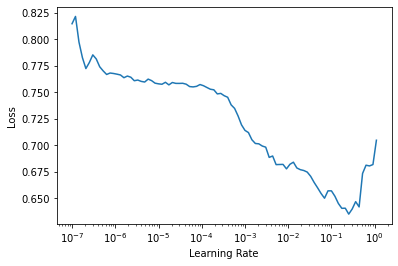

In [10]:
lr_min,lr_steep = classifier_b.lr_find()

In [16]:
print(f"Minimum/10: {lr_min} or {lr_min:.2e}, \nSteepest point: {lr_steep} or {lr_steep:.2e}")

Minimum/10: 0.025118863582611083 or 2.51e-02, 
Steepest point: 0.0030199517495930195 or 3.02e-03


In [7]:
classifier_b.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.456922,0.404286,0.815994,24:57


In [9]:
classifier_b.freeze_to(-2)
classifier_b.fit_one_cycle(1, slice(1e-2/(2.6**4), 2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.468043,0.390356,0.830247,31:48


In [11]:
classifier_b.unfreeze()
classifier_b.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.397946,0.372602,0.839944,1:13:40
1,0.411472,0.367006,0.842865,1:13:33
2,0.367541,0.359137,0.848356,1:13:26
3,0.365389,0.379038,0.839068,1:13:25


#TODO: Retrain the model again, since we slightly overfitted

In [13]:
classifier_b.save("classifier_on_train_backwards")

Path('models/classifier_on_train_backwards.pth')

In [14]:
# Load the classifier from the saved state (if continuing from a previous session)
classifier_b = classifier_b.load('classifier_on_train_backwards')

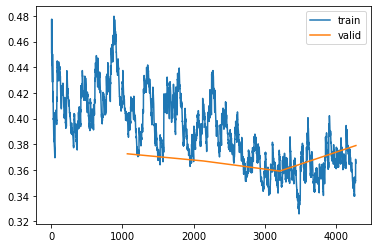

In [15]:
classifier_b.recorder.plot_loss()#skip_start=200)

In [29]:
text = """
First I think it needs to be said that the title of this book is inappropriate and uncalled for. It is an obvious play on Moore's own attempts at degrading and insulting others in his book "Stupid White Men". That said, it is simply unfortunate the authors here chose to dig a hole down to Moore's level because the information and facts in this book are too important to be dismissed because of the insulting book title. I fear that the factual information will not be read by those who are turned off by the title. I have enjoyed some of Moore's work, and in fact gave "Downside This" a favorable review here, but Moore obviously has some issue with his tactics, which are exposed in this book.In regards to the book content, it is excellent. I am sure by now that everyone knows Michael Moore is far from the "man of the people" he pretends to be. He is a very wealthy member of the celebrity circles, owns more than one million dollar home, and in fact is quite smug about his wealth. He charges up to 30k to speak out about the perils of wealthy, white men, which in a twist of irony he seems unaware of - he is. In fact several Moore quotes show a man who is overtly arrogant about his wealth and how he has become rich while other journalists are struggling by "playing by the rules".(page 120).In regards to his films and books, it is unfortunate he falsifies information to the extent he does. I think that he makes some good points. In "Bowling for Columbine" I agreed with his stance on gun control, yet he wasn't content with facts, he had to lie and misrepresent the truth to get there. For example, in one sequence he makes the claim that the young men who murdered their classmates did so while local corporation Lockheed-Martin rolled weapons of mass destruction through the streets. Well, not quite. Lockheed makes satellite rockets for placing satellites in space. (Page 87). What is even more disturbing is that this information was known, and filmed at the time, yet edited out.In "Roger and Me" Moore commits one of his favorite tactics. He goes with a film crew outside of the Waldorf-Astoria in New York, and a Yacht club in Michigan to try and film GM President Roger Smith. However, it was known to Moore that Smith had never stayed at the Waldorf and is not even a member of the Yacht Club, so obviously he wouldn't be filmed there. (Page 25) This tactic Moore uses often to try and paint a picture that is patently false and misrepresents the truth - deliberately. A bigger surprise for me is the quote from Moore that he doesn't even drive GM cars, preferring foreign cars! This is hardly the man of the people who took on a major corporation for laying off its workers at the GM plant in Flint Michigan, when the result of his own consumer choices places their jobs at risk.In "Fahrenheit 911" he commits yet another series of misrepresentations. I even know some people who are otherwise quite smart and level headed who were taken in by Moore's tactics. He claims that the Bush family has ties to the Bin Laden family. (Page 129). I would hope so. The Bin Laden family is huge, something like 50 or so sons. They are one of the wealthiest and most influential in Saudi and lean heavily towards the west and America. Having long since disowned "Osama" (who considers them all to be traitors to Islam) they are allies to our cause in the Middle East. He claims that Bush invited the Taliban government to Texas. Well in fact it was President Clinton who authorized and endorsed the visit, and Clinton who was supporting a pipeline which would have benefited the Taliban, while Bush opposed it. (Page 177). There are too many other discrepancies to count.Overall, the book is full of factual and well documented information, though often redundant, and mean-spirited in its presentation. There are hundreds of Moore's lies and mistruths uncovered and exposed. While this may align to Moore's own style itself, I expected better from them, therefore only three stars. The index itself is worth reviewing. If you are a fan of Moore's then continue to admire his talent in making fictional films to make his own self serving political points, but educate yourself on the truth behind his claims to better decide these issues for yourself.	
"""


classifier_b.predict(text)

('1', tensor(1), tensor([0.3805, 0.6195]))

Now that we have the two classifiers - the one trained normally and the other trained backwards, let's check how many mis-predictions from earlier can we now correct (by averaging their softmax predicted values)

In [18]:
# Load the predictions that were saved previously
preds_df = pd.read_csv("predictions_on_test_step10.csv")
incorrect_preds = preds_df[preds_df['actual'] != preds_df['predicted']]
incorrect_preds

,text,actual,predicted
2,"Somewhere in the Sherlock Holmes stories there is an episode where Holmes slyly sets a little test for Watson. Holmes has already checked out the mystery du jour but, without letting on, deputes Watson to take a second look. Watson reports back in plodding and largely irrelevant detail, as Holmes impassively listens. Finally Holmes thunders: ""Watson, you have noted everything but what is significantc.You see but do not observe.""Anyone familiar with the geopolitical ground covered in this book can be forgiven a similar harrumph. While Kamen's account consistently holds the reader's interes...",1,0
6,"I have skimmed over a few chapters in this book and am really disappointed. Obviously, our understanding of addictions and how to treat them has a long way to go.The author goes on about the iron control one must have over every bite put into your mouth in order to control the ""disease"". Her diet (just another diet approach, only even less realistic than most) involves measuring ALL foods for the rest of your life, as well as eliminating ALL flour, refined sugars, wheat, and several other food groups ENTIRELY from your diet - for the rest of your life! (check out [...] to see what I mea...",0,1
17,"Professor DiLorenzo's book is a systematic, scholarly, and relentless refutation of the Lincoln myth. No wonder it's causing such hysterics among the mythmakers.In this highly readable book, Professor DiLorenzo takes the reader through a number of major points, in each case providing more than ample evidence for his position. He shows that what really moved Lincoln and his partisans was not slavery but the Whig economic program of high tariffs, national banking, and the corporate welfare that is euphemistically called ""internal improvements."" Lincoln as righteous opponent of slavery has...",0,1
20,"Any valuable information contained in this book is completely lost in a muddle of infuriatingly CRAP writing. This editor was asleep at the wheel. I mean, seriously-- WTF? How many times can an author belabor the vampire metaphor? ""... and, just like a vampire, narcissists hypnotize you."" ""...and just like a vampire, they are creatures of darkness."" ""...and just like a vampire, you have to invite them in."" ""... and just like a vampire, they can't see themselves in the mirror."" Oh, for God's sakes! Just like a vampire, this writer can bite me.",0,1
30,"I actually felt somewhat guilty for not enjoying this book more. But I appear to be the sole dissenter here.Positives first: Mr. McBride is a very graceful writer. His prose is fluid and easy, a breezy read, and he has a gift for description.And, there is no doubt that the subject of the book, the author's mother, is a remarkable woman and quite a story. She came into the world with terrible odds against her; a foreigner in a foreign land, an outsider by ethnicity and religion, poor, molested by her father, with a disabled mother who was also a victim of abuse, and with no real support...",0,1
...,...,...,...
2094,"I have always admired Ms. Rice for her accomplishments as a woman and especially as a black woman growing up in the segregated South. And so I eagerly awaited her memoir, hoping to gain more insight into this seemingly remarkable woman. But it was a complete disappointment. It was nothing more than a summary of the facts that were already known about her life. I keep wondering why she even bothered to write this book. She comes across as wooden. There are no musing about the trials and tribulations of life; for example, how she dealt with adversity - from segregation and racism to the pol...",0,1
2113,"Obviously Pro-Bush supporters will keep their blinders on and dimiss anything that tells the truth about the disgusting Bush family, their lies and hatred of the average American. I am ashamed to be a Republican.",1,0
2127,"""""What is my narrative?"" he all but shouted. ""I don't have a narrative.""That's Barack Obama reacting to the election of S

In [66]:
def pred(row):
    """Do final predictions based on the two classifiers"""
    pred = classifier.predict(row["text"])
    pred_backwards = classifier_b.predict(row["text"])
    avg_pred = torch.stack((pred[2], pred_backwards[2])).mean(0)    # take mean along the columns
    # Output the class that has higher averaged probability
    return 1 if avg_pred[1] > avg_pred[0] else 0

incorrect_preds["predicted_backwards"] = incorrect_preds.apply(pred, axis=1) 

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [69]:
incorrect_preds.sample(3)

,text,actual,predicted,predicted_backwards
588,"I have the utmost respect for President Bush after reading about the trials and tribulations of his life and his presidency. He is a thoughtful, kind, and intelligent man who stood by his oath to protect America and follow principles that advanced our economy. His policies promoted economic growth and helped to prevent a second Great Depression. But because of terrorism, he had to bring the war to the terrorists and unfortunately that has been costly. While mostly everyone in congress and many societies saw the necessity of our invading Afganistan and Iraq after considering the evidenc...",0,1,1
1604,"The most important advice in this book is on page 55 where the author advises you to figure out your profit before you buy. The only way you could be sure you have a profit when you purchase would be if you already had a contract to sell for a profit, at the same time. If you can pull that trick off, congratulations, you are an exceptionally skilled rehabber. But most rehabbers own the property for months or longer; if during this holding period one of the big real estate bubbles should burst profits will be blown away and significant losses could be suffered. For example, a rehabber c...",0,1,1
1853,"I purchased this book to learn lighting techniques. It came highly recommended by other photographers. What I got was a VERY TECHNICAL physics book. Now, I am not dumb by any means, I even have a background in science and have taken my share of physics courses, but I found my eyes glazing over every other sentence because it was VERY WORDY and VERY DIFFICULT to read. If it weren't for the couple of diagrams and pictures throughout the book...I probably woulndn't have gotten anything from it.What I am trying to say is, if you are a physics geek and/or you learn by reading then this is fo...",0,1,1


In [72]:
# Predictions where the 'predicted' and 'predicted_backwards' don't match indicate that we have correctly predicted
# the actual behavior (a double negative!), and our strategy to train a model backwards paid off
corrected_preds = incorrect_preds[incorrect_preds['predicted'] != incorrect_preds['predicted_backwards']]
corrected_preds

,text,actual,predicted,predicted_backwards
2,"Somewhere in the Sherlock Holmes stories there is an episode where Holmes slyly sets a little test for Watson. Holmes has already checked out the mystery du jour but, without letting on, deputes Watson to take a second look. Watson reports back in plodding and largely irrelevant detail, as Holmes impassively listens. Finally Holmes thunders: ""Watson, you have noted everything but what is significantc.You see but do not observe.""Anyone familiar with the geopolitical ground covered in this book can be forgiven a similar harrumph. While Kamen's account consistently holds the reader's interes...",1,0,1
20,"Any valuable information contained in this book is completely lost in a muddle of infuriatingly CRAP writing. This editor was asleep at the wheel. I mean, seriously-- WTF? How many times can an author belabor the vampire metaphor? ""... and, just like a vampire, narcissists hypnotize you."" ""...and just like a vampire, they are creatures of darkness."" ""...and just like a vampire, you have to invite them in."" ""... and just like a vampire, they can't see themselves in the mirror."" Oh, for God's sakes! Just like a vampire, this writer can bite me.",0,1,0
109,"First, the thesis of The God Code is an intriguing one. I applaud new and creative ideas that attempt to meld science and spirituality. Nonetheless, some aspects of the book I found a bit difficult to get down with. Some of these one could reasonably expect an editor or proofreaders to catch, as accidental typos and incorrect transcriptions do happen. There are several in this text. Without tiring you with a list, let me give one example: on page 16, Braden states Pioneer 10 is almost 11 light years away, and then he writes it took 11 hours to send a signal to it from Earth. Nothing humans...",1,0,1
131,"Fire - a timeless subject. Perhaps rivalling the wheel in terms of its importance in human development, fire has been an important companion in our teleological quest towards perfection. This book didn't really directly tackle the subject of fire as poignantly as would suit my tastes. If you're interested in furthering your knowledge of fire I recommend the movie ""Quest for Fire"", the song ""Fire"" by Arthur Brown, and ""Backdraft.""",0,1,0
147,"I've had to wade through a lot of postmodern, ""poststructuralist"" muck in my day -...- but this by far takes the cake. (The world's worst translation of _Simulacra and Simulation_ has nothing on this!) Lest you miss out on the choice narrative style, here's a synopsis:""Deleuze wants language to be encountered as communication which codes and 'over-codes' desires, which territorializes and 'deterritorializes' power, and which spreads and 'organizes' in the patterns of rhizomes. He challenges us to recognize in language an aspect where meaning and reference are less important than pattern,...",0,1,0
...,...,...,...,...
1997,"This book came highly recommended by a family friend, so I was surprised to find it bland, muddled, vague, and rambling.The philosophy of total hopelessness and apathy Chodron offers up seems to me to be an impoverished distortion of the central Buddhist truths of impermanence and suffering. The book offers virtually no wisdom on the questions of how to live and act as a human being in the world. Her reduction of politics to a question of personal animosity is naive and dangerous. Her presentation of Buddhist concepts is imprecise, and her examples don't come alive for me.For those hoping ...",0,1,0
2048,"Verbatim from &quot;Against All Enemies&quot; by Richard Clarke, starting at page 140. Any typos are probably mine.THROUGHOUT BIN LADEN'S YEARS in Sudan, that country served as a base for arms and fighters going not just to Bosnia but also to terrorists in Egypt, Ethiopia, Uganda, and even Qadhafi's Libya. Sudan's intelligence service and military supported the terrorists. Then in June 1995, Egyptian President Hosni Mubarak flew to Ethiopia for a meeting in 

In [78]:
print("Final accuracy", 1. - (len(incorrect_preds) - len(corrected_preds)) / len(preds_df))

Final accuracy 0.8822429906542056
